# 2021.05.11 污泥项目工作进展

## 1.预测流程与灵敏度分析

## 2.甲烷排放量估算

## 3.共享社会经济路径研究综述

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn import ensemble
import matplotlib
#plt.style.use(['science','ieee','no-latex'])
#plt.rcParams['font.sans-serif']=['SimHei']    #指定默认字体 SimHei为黑体
#plt.rcParams['axes.unicode_minus']=False   #用来|正常显示负号
#matplotlib.rcParams['font.family'] = 'SimHei'  
#matplotlib.rcParams['font.sans-serif'] = 'NSimSun,Times New Roman'

In [2]:
#读取文件
train_pro = pd.read_csv('分省.csv', encoding='utf-8')
#display(train_pro.info())
#display(train_pro.head())

train_city = pd.read_csv('地级市.csv', encoding='utf-8')
#display(train_city.info())
#display(train_city.head())

validition = pd.read_csv('验证集.csv', encoding='utf-8')
#display(validition.info())
#display(validition.head())

prediction = pd.read_csv('预测集.csv', encoding='utf-8')
#display(prediction.info())
#display(prediction.head())

In [3]:
#训练col

#col = ['GDP','POP']
col = ['GDP','LDP','BA','POP','CCF']

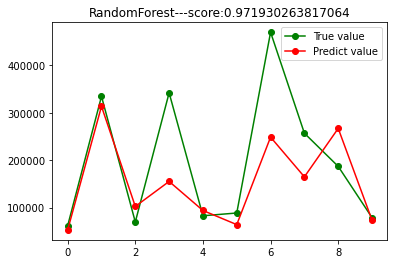

In [4]:
#训练模型_分省
train_pro_dna = train_pro.dropna()

X = train_pro_dna[col].values
Y = train_pro_dna.loc[:, 'SLUDGE'].values

x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.3,random_state=0)

forest = RandomForestRegressor(
    n_estimators=3000,
    random_state=0,
    n_jobs=-1)
forest.fit(x_train,y_train)

score_test = forest.score(x_test, y_test)
result_test = forest.predict(x_test)
plt.figure()
#只取前一百条可视化，因为数据太多了
plt.plot(np.arange(10), y_test[:10], "go-", label="True value")
plt.plot(np.arange(10), result_test[:10], "ro-", label="Predict value")
plt.title(f"RandomForest---score:{score_test}")
plt.legend(loc="best")
plt.show()


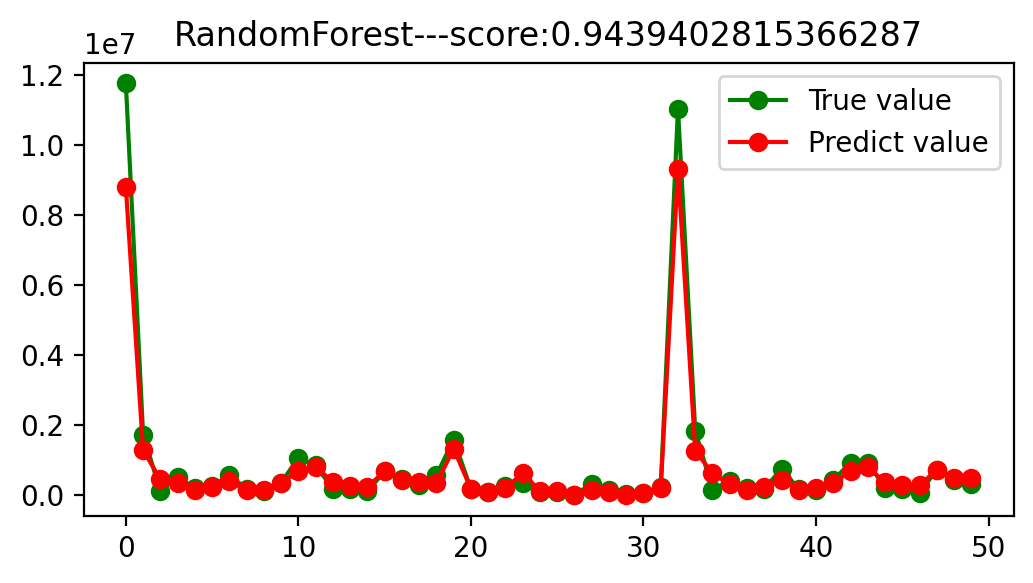

重要性： [0.20681577 0.20888738 0.19977249 0.1907214  0.19380296]
 1) LDP                            0.208887
 2) GDP                            0.206816
 3) BA                             0.199772
 4) CCF                            0.193803
 5) POP                            0.190721


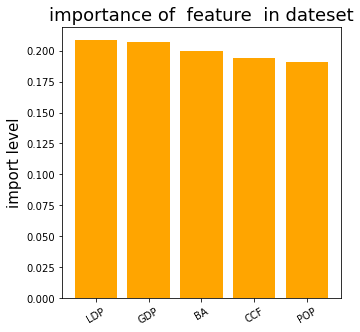

In [5]:
#验证集
validition_vald = validition[col]
score_vald = forest.score(validition_vald, validition['SLUDGE'])
result_vald = forest.predict(validition_vald)

plt.figure(figsize=(6,3), dpi=200)
plt.plot(np.arange(50), validition['SLUDGE'][:50], "go-", label="True value")
plt.plot(np.arange(50), result_vald[:50], "ro-", label="Predict value")
plt.title(f"RandomForest---score:{score_vald}")
plt.legend(loc="best")
plt.show()
# 下面对训练好的随机森林，完成重要性评估
# feature_importances_  可以调取关于特征重要程度
importances = forest.feature_importances_
print("重要性：", importances)
x_columns = col
#返回数组从大到小的索引值
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    # 对于最后需要逆序排序，我认为是做了类似决策树回溯的取值，从叶子收敛
    # 到根，根部重要程度高于叶子。
    print("%2d) %-*s %f" % (f + 1, 30, col[indices[f]], importances[indices[f]]))

# 筛选变量（选择重要性比较高的变量）
threshold = 0.15
x_selected = x_train[:, importances > threshold]

# 可视化

plt.figure(figsize=(5, 5))
plt.title("importance of  feature  in dateset", fontsize=18)
plt.ylabel("import level", fontsize=15, rotation=90)

x_columns1 = [x_columns[i] for i in indices]
for i in range(len(x_columns)):
    plt.bar(i, importances[indices[i]], color='orange', align='center')
    plt.xticks(np.arange(len(x_columns)), x_columns1, fontsize=10, rotation =30)


In [6]:
def sen_var_5(df, col, sen):
    """
    改变预测集自变量范围，用于不确定性分析
    
    Args:
        df (DataFrame):需要进行不确定性分析的df
        col (List):-变量名称
        sen (float):不确定性，为小数
    Returns：
        None
    """
    for c in col:
        df[c + '+'] = df[c]*(1 + sen)
        df[c + '-'] = df[c]*(1 - sen)
    
sen_var_5(prediction, col, 0.05)


neg_var = []
pos_var = []



for i in col:
    neg_var.append(i + "-")
    pos_var.append(i + '+')
    

In [7]:
#预测模型
def pred_forest(df, col):
    """
    实现随机森林模型的预测
    
    Args:
        df (DataFrame):预测集
        col (List):-输入特征
    Returns：
        Series：预测结果
    """
    pred = df[col]
    result_pred = forest.predict(pred)
    return result_pred


#绘制全国污泥产量预测图
def draw_nation(result, alpha=1, linestyle='-'):
    
    #sns.set_context('talk')
    
    plt.plot(SSP1['YEAR'], SSP1[result], color='green', alpha=alpha, linestyle=linestyle);
    plt.plot(SSP2['YEAR'], SSP2[result], color='darkorange', alpha=alpha, linestyle=linestyle);
    plt.plot(SSP3['YEAR'], SSP3[result], color='purple', alpha=alpha, linestyle=linestyle);
    plt.plot(SSP4['YEAR'], SSP4[result], color='deepskyblue', alpha=alpha, linestyle=linestyle);
    plt.plot(SSP5['YEAR'], SSP5[result], color='red', alpha=alpha, linestyle=linestyle);

In [8]:
#拟合预测结果
def poly_res(result, n):
    """
    对预测数据拟合，结果更平滑
    
    Args:
        result (pd.Series):预测结果
        n (int):多项式拟合阶数
    Returns：
        dict：不同SSP拟合结果字典
    """
    para_ssp1 = np.polyfit(SSP1['YEAR'], SSP1[result], n)
    parameter_ssp1 = np.poly1d(para_ssp1)
    para_ssp2 = np.polyfit(SSP2['YEAR'], SSP2[result], n)
    parameter_ssp2 = np.poly1d(para_ssp2)
    para_ssp3 = np.polyfit(SSP3['YEAR'], SSP3[result], n)
    parameter_ssp3 = np.poly1d(para_ssp3)
    para_ssp4 = np.polyfit(SSP4['YEAR'], SSP4[result], n)
    parameter_ssp4 = np.poly1d(para_ssp4)
    para_ssp5 = np.polyfit(SSP5['YEAR'], SSP5[result], n)
    parameter_ssp5 = np.poly1d(para_ssp5)
    
    return {'poly_ssp1':parameter_ssp1, 'poly_ssp2':parameter_ssp2 ,'poly_ssp3':parameter_ssp3 ,
            'poly_ssp4':parameter_ssp4 ,'poly_ssp5':parameter_ssp5}


def draw_poly(SSP, para_m, para_n, para_p, poly_ssp, color, label):
    """
    画不确定性区间图
    
    Args:
        SSP (pd.DataFrame):数据框
        para_m (dict)：预测值拟合参数
        para_n (dict)：不确定性下限拟合参数
        para_p (dict)：不确定性上限拟合参数
        label (str):标签
    Returns：
        dict：不同SSP拟合结果字典
    """
    plt.plot(SSP['YEAR'], para_m[poly_ssp](SSP['YEAR'])/10000, color=color, linestyle='-',
             alpha=1,label=label)
    plt.plot(SSP['YEAR'], para_n[poly_ssp](SSP['YEAR'])/10000, color=color, linestyle='--',
             alpha=0.5)
    plt.plot(SSP['YEAR'], para_p[poly_ssp](SSP['YEAR'])/10000, color=color, linestyle='--',
             alpha=0.5)
    plt.fill_between(SSP['YEAR'], para_n[poly_ssp](SSP['YEAR'])/10000,
                 sludge_p[poly_ssp](SSP['YEAR'])/10000,
                 facecolor=color, alpha=0.5, label='Uncertainties')
    plt.xticks(weight='bold')
    plt.yticks(weight='bold')



In [9]:
def save_poly(SSP, para_m, para_n, para_p, poly_ssp):
    pm = para_m[poly_ssp](SSP['YEAR'])
    pn = para_n[poly_ssp](SSP['YEAR'])
    pp = para_p[poly_ssp](SSP['YEAR'])
    return {'pm':pm, 'pn':pn, 'pp':pp}

In [10]:
SSP1

NameError: name 'SSP1' is not defined

In [11]:
SSP1.merge(pd.DataFrame(save_poly(SSP1,  sludge_mean, sludge_n, sludge_p, 'poly_ssp1')), on=SSP1.index).to_excel('Country_result_SSP1.xlsx', sheet_name='SSP1')

NameError: name 'SSP1' is not defined

In [12]:
SSP2.merge(pd.DataFrame(save_poly(SSP2,  sludge_mean, sludge_n, sludge_p, 'poly_ssp2')), on=SSP2.index).to_excel('Country_result_SSP2.xlsx', sheet_name='SSP2')
SSP3.merge(pd.DataFrame(save_poly(SSP3,  sludge_mean, sludge_n, sludge_p, 'poly_ssp3')), on=SSP3.index).to_excel('Country_result_SSP3.xlsx', sheet_name='SSP3')
SSP4.merge(pd.DataFrame(save_poly(SSP4,  sludge_mean, sludge_n, sludge_p, 'poly_ssp4')), on=SSP4.index).to_excel('Country_result_SSP4.xlsx', sheet_name='SSP4')
SSP5.merge(pd.DataFrame(save_poly(SSP5,  sludge_mean, sludge_n, sludge_p, 'poly_ssp5')), on=SSP5.index).to_excel('Country_result_SSP5.xlsx', sheet_name='SSP5')

NameError: name 'SSP2' is not defined

In [13]:
#预测集

prediction['result'] = pred_forest(prediction, col)
prediction['result-'] = pred_forest(prediction, neg_var)
prediction['result+'] = pred_forest(prediction, pos_var)

prediction_group = prediction.groupby(['SSP','YEAR']).sum().reset_index()


SSP1 = prediction_group[prediction_group['SSP'] == 'SSP1']
SSP2 = prediction_group[prediction_group['SSP'] == 'SSP2']
SSP3 = prediction_group[prediction_group['SSP'] == 'SSP3']
SSP4 = prediction_group[prediction_group['SSP'] == 'SSP4']
SSP5 = prediction_group[prediction_group['SSP'] == 'SSP5']

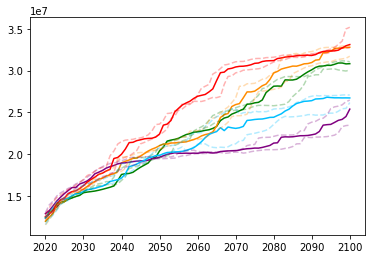

In [14]:
#画图
draw_nation('result')
draw_nation('result-',linestyle='--', alpha=0.3)
draw_nation('result+',linestyle='--', alpha=0.3)

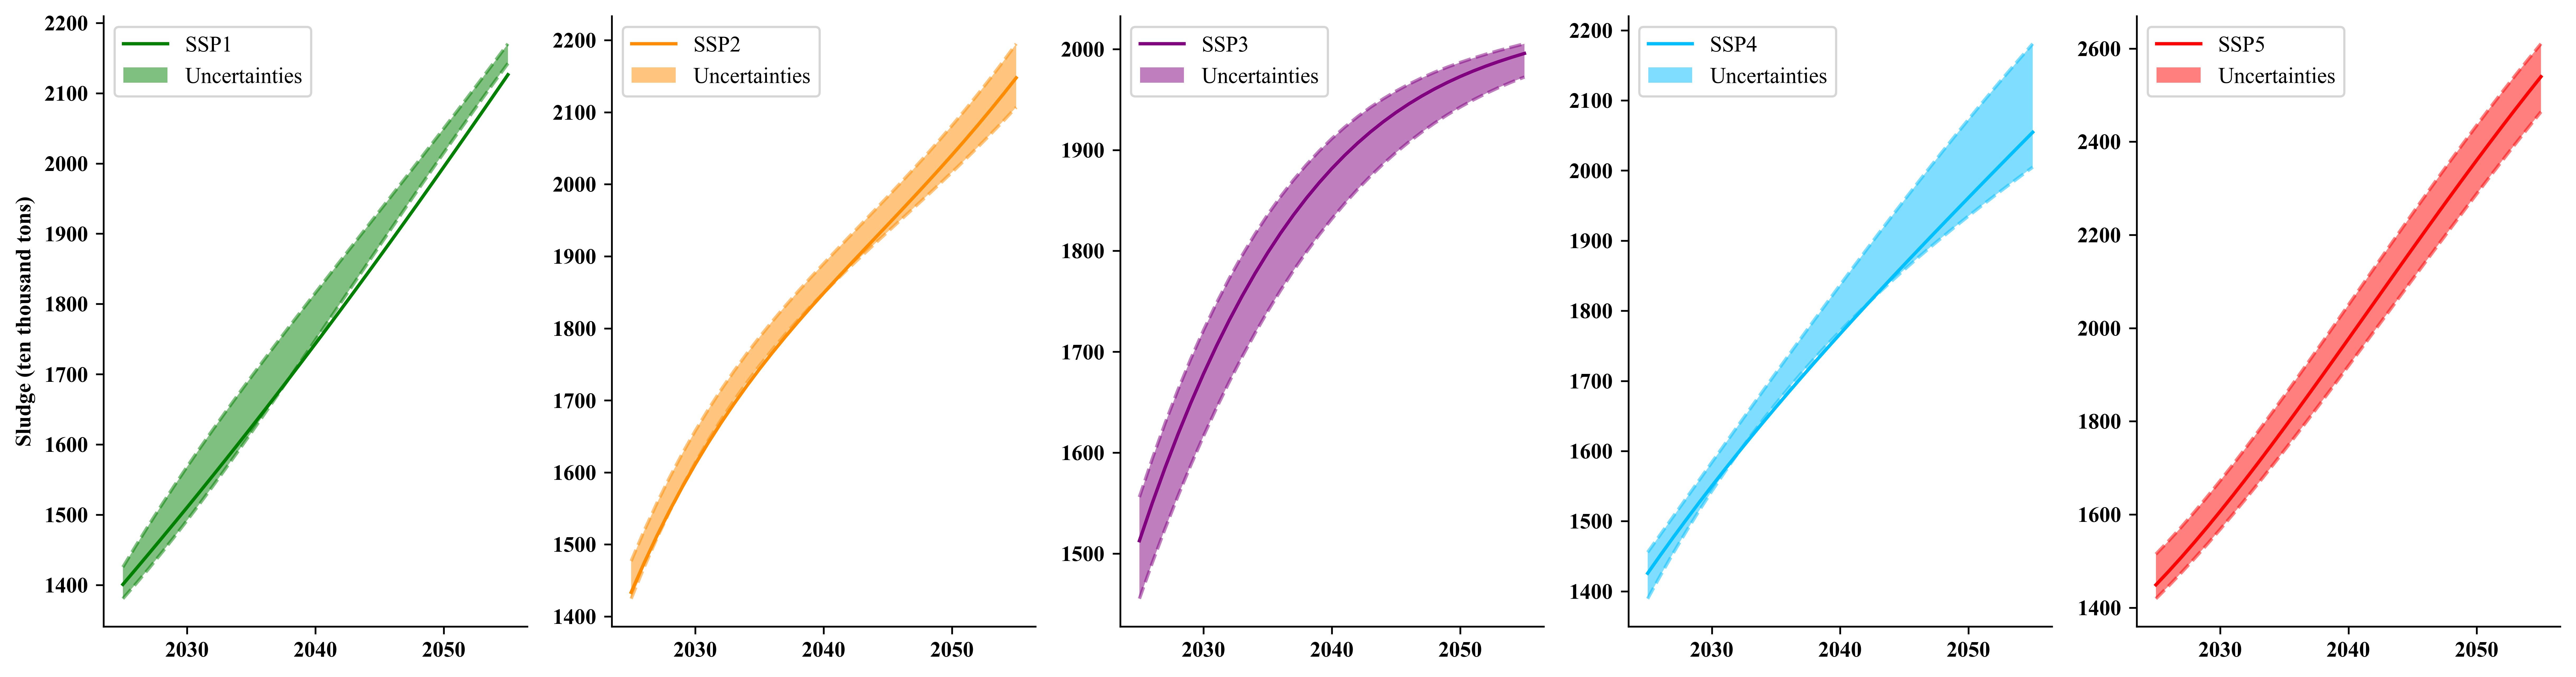

In [19]:
#画拟合图_简易灵敏度分析
#new = SSP1['result-'] + 100000
#SSP1 = SSP1.drop('result-', axis=1)
#SSP1['result-'] = new

matplotlib.rcParams['font.sans-serif'] = 'NSimSun,Times New Roman'
sludge_mean = poly_res('result', 4)
sludge_n = poly_res('result+', 4)
sludge_p = poly_res('result-', 4)

plt.figure(figsize=(20,5), dpi=600)
plt.subplot(1,5,1)
draw_poly(SSP1[(SSP1['YEAR'] <= 2055) & (SSP1['YEAR'] >= 2025)], sludge_mean, sludge_n, sludge_p, 'poly_ssp1', color='green', label='SSP1')
plt.ylabel('Sludge (ten thousand tons)', weight='bold')
plt.legend()

plt.subplot(1,5,2)
draw_poly(SSP2[(SSP2['YEAR'] <= 2055) & (SSP2['YEAR'] >= 2025)], sludge_mean, sludge_n, sludge_p, 'poly_ssp2', color='darkorange', label='SSP2')
plt.legend()



plt.subplot(1,5,3)
draw_poly(SSP3[(SSP3['YEAR'] <= 2055) & (SSP3['YEAR'] >= 2025)], sludge_mean, sludge_n, sludge_p, 'poly_ssp3', color='purple', label='SSP3')
plt.legend()

plt.subplot(1,5,4)
draw_poly(SSP4[(SSP4['YEAR'] <= 2055) & (SSP4['YEAR'] >= 2025)], sludge_mean, sludge_n, sludge_p, 'poly_ssp4', color='deepskyblue', label='SSP4')
plt.legend()


plt.subplot(1,5,5)
draw_poly(SSP5[(SSP5['YEAR'] <= 2055) & (SSP5['YEAR'] >= 2025)], sludge_mean, sludge_n, sludge_p, 'poly_ssp5', color='red', label='SSP5')
plt.legend()
sns.despine()

plt.savefig('Uncertainties.jpg', dpi=600, bbox_inches='tight')

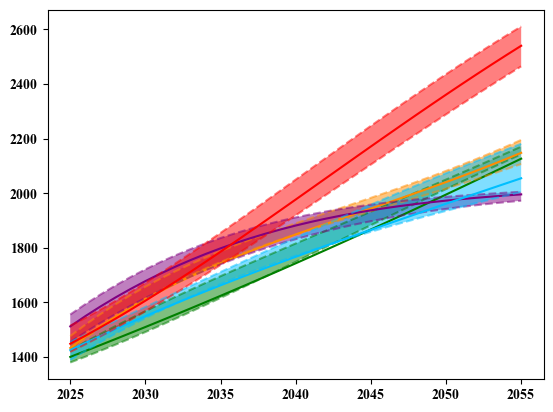

In [29]:
draw_poly(SSP1[(SSP1['YEAR'] <= 2055) & (SSP1['YEAR'] >= 2025)], sludge_mean, sludge_n, sludge_p, 'poly_ssp1', color='green', label='SSP1')
draw_poly(SSP2[(SSP2['YEAR'] <= 2055) & (SSP2['YEAR'] >= 2025)], sludge_mean, sludge_n, sludge_p, 'poly_ssp2', color='darkorange', label='SSP2')
draw_poly(SSP3[(SSP3['YEAR'] <= 2055) & (SSP3['YEAR'] >= 2025)], sludge_mean, sludge_n, sludge_p, 'poly_ssp3', color='purple', label='SSP3')
draw_poly(SSP4[(SSP4['YEAR'] <= 2055) & (SSP4['YEAR'] >= 2025)], sludge_mean, sludge_n, sludge_p, 'poly_ssp4', color='deepskyblue', label='SSP4')
draw_poly(SSP5[(SSP5['YEAR'] <= 2055) & (SSP5['YEAR'] >= 2025)], sludge_mean, sludge_n, sludge_p, 'poly_ssp5', color='red', label='SSP5')

In [39]:
SSP5[(SSP5['YEAR'] <= 2055) & (SSP5['YEAR'] >= 2025)][['YEAR','result', 'result-','result']]

,YEAR,result,result-,result
329,2025,1.476932e+07,1.493420e+07,1.476932e+07
330,2026,1.525635e+07,1.527953e+07,1.525635e+07
331,2027,1.551928e+07,1.542640e+07,1.551928e+07
332,2028,1.562554e+07,1.554144e+07,1.562554e+07
333,2029,1.588537e+07,1.575385e+07,1.588537e+07
334,2030,1.623975e+07,1.575708e+07,1.623975e+07
335,2031,1.665455e+07,1.600699e+07,1.665455e+07
336,2032,1.696598e+07,1.639448e+07,1.696598e+07
337,2033,1.725226e+07,1.670681e+07,1.725226e+07
338,2034,1.758637e+07,1.690736e+07,1.758637e+07


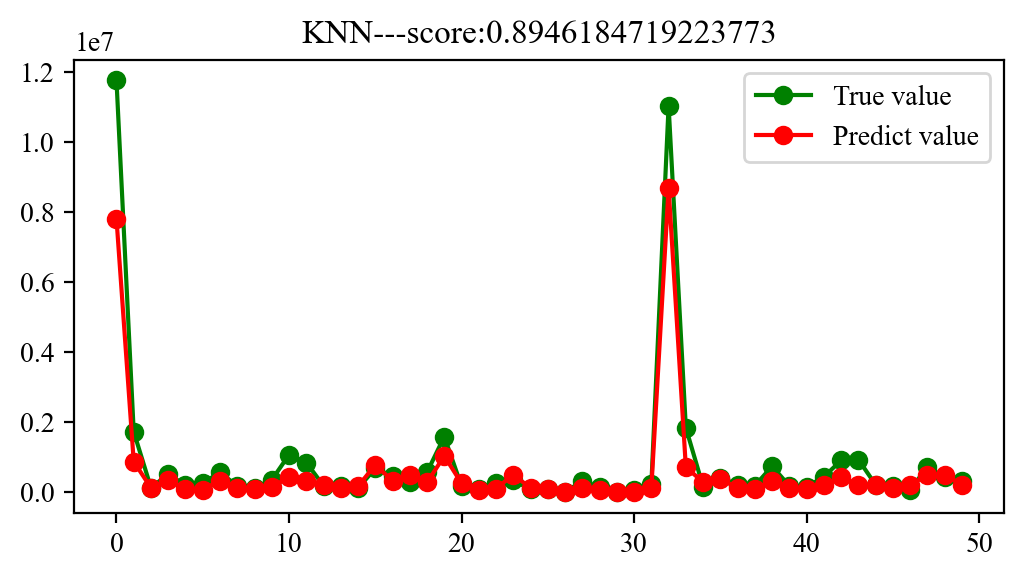

In [16]:
#KNN算法
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 5)
train_pro_dna = train_pro.dropna()

X = train_pro_dna[col].values
Y = train_pro_dna.loc[:, 'SLUDGE'].values
knn.fit(X, Y)
validition_vald = validition[col]
score_vald = knn.score(validition_vald, validition['SLUDGE'])
result_vald = knn.predict(validition_vald)

plt.figure(figsize=(6,3), dpi=200)
plt.plot(np.arange(50), validition['SLUDGE'][:50], "go-", label="True value")
plt.plot(np.arange(50), result_vald[:50], "ro-", label="Predict value")
plt.title(f"KNN---score:{score_vald}")
plt.legend(loc="best")
plt.show()

计算生活污水处理的甲烷排放

步骤一：获取活动水平数据。根据《中国环境统计年鉴》获得排入环境中的 COD 排放量和污水处理厂处理系统去除的 COD 量，根据各省区市的污水处理厂实际情况测定 BOD/COD 的值，此处采用推荐值：0.48
 
步骤二：确定排放因子。首先根据公式 5.8 计算甲烷修正因子，如果没有省区市特有的甲烷修正因子，建议采用指南推荐值，其次根据实际情况获得甲烷最大产生能力，如果不可获得建议采用推荐值：0.165
 
步骤三：根据活动水平数据和排放因子，利用公式 5.6 估算得出排入环境的生活污水和污水处理厂处理系统产生的甲烷排放量，最后求和得出生活污水处理的甲烷排放量。

以2016年《中国环境统计年鉴》中给出的各行业COD排放量为准

In [17]:
#计算生活污水处理系统中的CH4排放

#读取数据
data = pd.ExcelFile('2016_CH4.xlsx')
CH4_2016 = data.parse('Sheet1')

#参数率定
B0 = 0.6
MCF = 0.165
BOD_to_COD = 0.48

#COD转换为BOD
for col in ['COD_ALL', 'COD_IND', 'COD_AGR', 'COD_HOU', 'COD_CPC']:
    CH4_2016['BOD' + col] = CH4_2016[col] * BOD_to_COD
    
    
EF = B0 * MCF

#计算CH4
for col in CH4_2016.columns[6:11]:
    CH4_2016['CH4' + col] = CH4_2016[col] * EF
CH4_2016.head()

,PROVINCE,COD_ALL,COD_IND,COD_AGR,COD_HOU,COD_CPC,BODCOD_ALL,BODCOD_IND,BODCOD_AGR,BODCOD_HOU,BODCOD_CPC,CH4BODCOD_ALL,CH4BODCOD_IND,CH4BODCOD_AGR,CH4BODCOD_HOU,CH4BODCOD_CPC
0,Beijing,161536,4738,72181,79396,5221,77537.28,2274.24,34646.88,38110.08,2506.08,7676.19072,225.14976,3430.04112,3772.89792,248.10192
1,Tianjin,209099,28058,102467,77944,629,100367.52,13467.84,49184.16,37413.12,301.92,9936.38448,1333.31616,4869.23184,3703.89888,29.89008
2,Hebei,1208059,136539,829326,236512,5682,579868.32,65538.72,398076.48,113525.76,2727.36,57406.96368,6488.33328,39409.57152,11239.05024,270.00864
3,Shanxi,405058,68709,159198,174471,2680,194427.84,32980.32,76415.04,83746.08,1286.40,19248.35616,3265.05168,7565.08896,8290.86192,127.35360
4,Inner Mongolia,835604,97402,591160,144724,2318,401089.92,46752.96,283756.80,69467.52,1112.64,39707.90208,4628.54304,28091.92320,6877.28448,110.15136


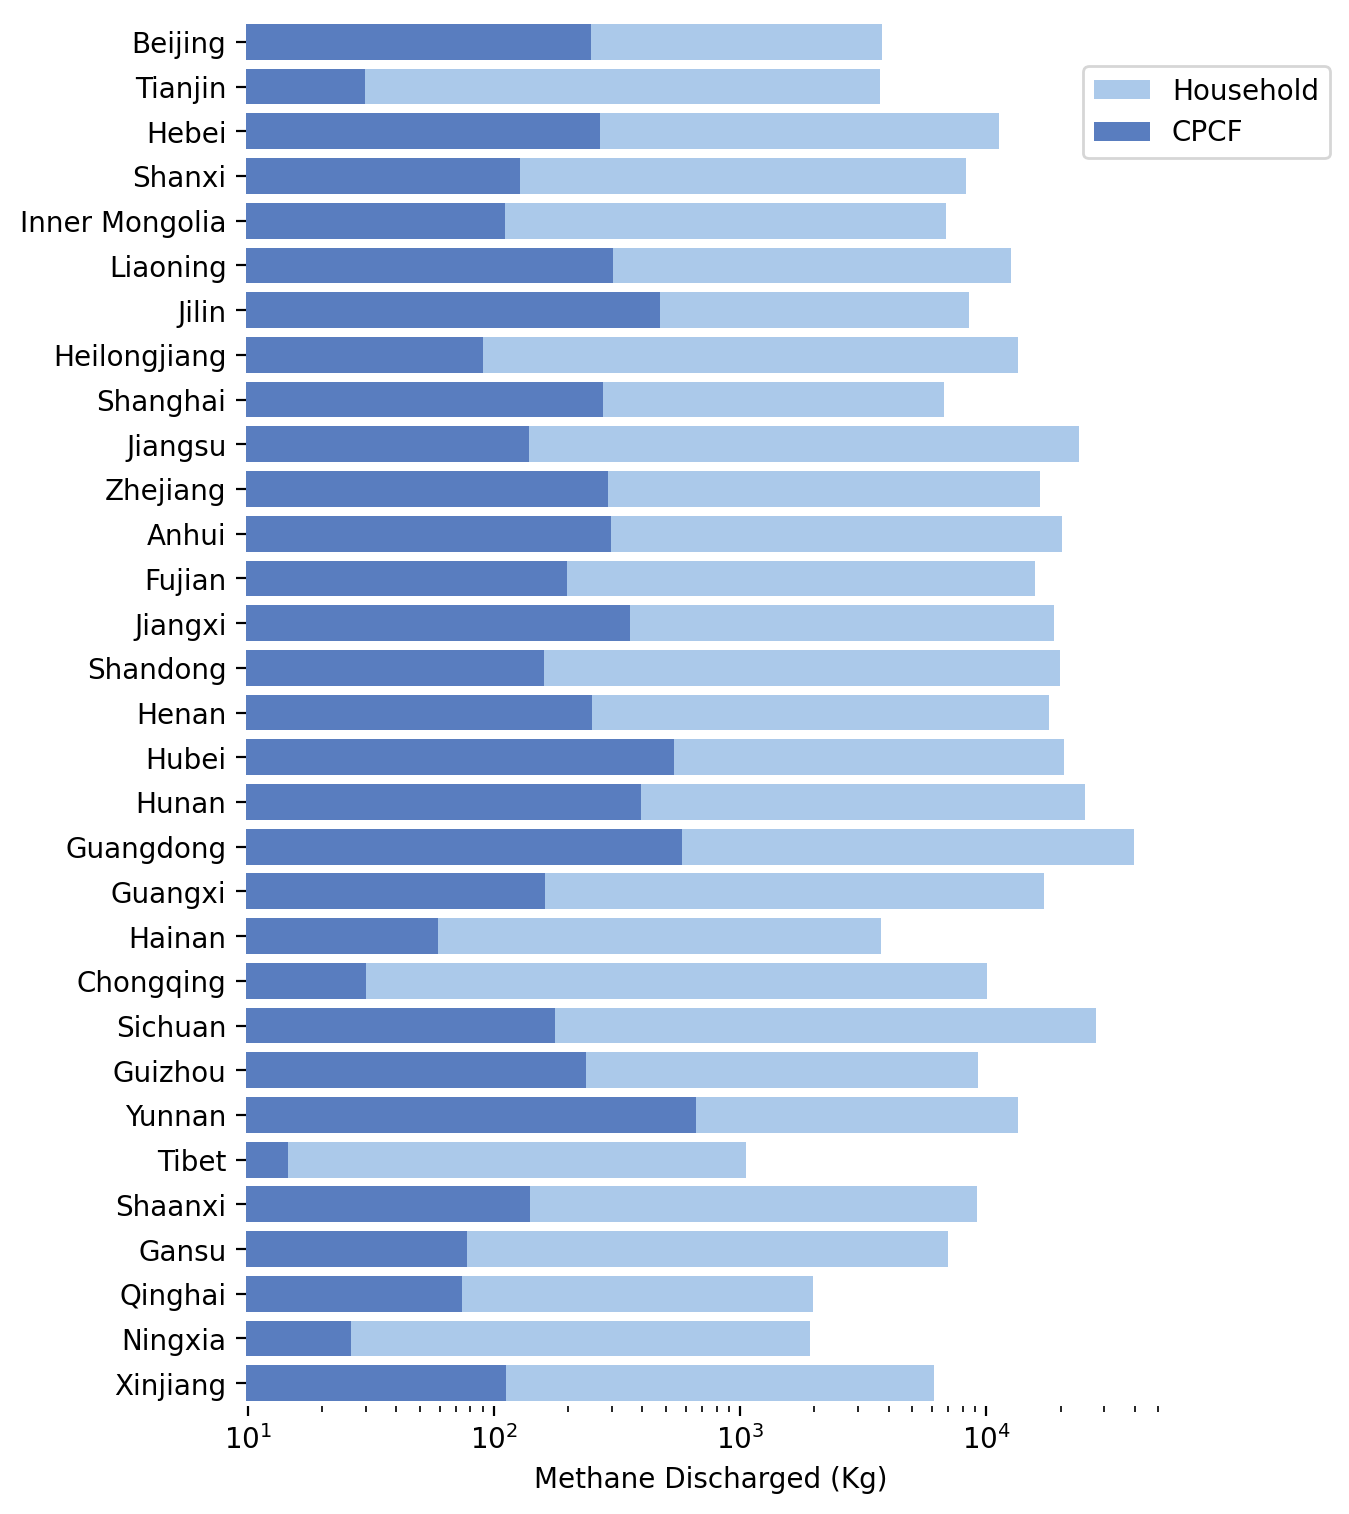

In [18]:
#画图

plt.style.use('default')
plt.figure(figsize=(6,9), dpi=200)

sns.set_color_codes("pastel")
sns.barplot(y="PROVINCE", x="CH4BODCOD_HOU", data=CH4_2016,
            label="Household", color="b")

sns.set_color_codes("muted")
sns.barplot(y="PROVINCE", x="CH4BODCOD_CPC", data=CH4_2016,
            label="CPCF", color="b")

plt.xscale('log')
plt.ylabel(None)
plt.xlabel('Methane Discharged (Kg)')
plt.legend(loc=(0.9,0.9))
sns.despine(left=True, bottom=True)

Zhang Fan et al. China's energy-related carbon emissions projections for the shared socioeconomic pathways[J]. Resources, Conservation & Recycling, 2021, 168

P.J.T.M. van Puijenbroek and A.H.W. Beusen and A.F. Bouwman. Global nitrogen and phosphorus in urban waste water based on the Shared Socio-economic pathways[J]. Journal of Environmental Management, 2019, 231 : 446-456.

Zhang Xiaoxin et al. Modelling phosphorus loading to the largest shallow lake in northern China in different shared socioeconomic pathways[J]. Journal of Cleaner Production, 2021, 297

Xu Xiaocong and Zhang Yuanying and Chen Yimin. Projecting China's future water footprint under the shared socio-economic pathways[J]. Journal of Environmental Management, 2020, 260

David R. Kanter et al. A framework for nitrogen futures in the shared socioeconomic pathways[J]. Global Environmental Change, 2020, 61  

Zhaohai Bai et al. Global environmental costs of China's thirst for milk[J]. Global Change Biology, 2018, 24(5) : 2198-2211.

Mengru Wang et al. Reactive nitrogen losses from China's food system for the shared socioeconomic pathways (SSPs)[J]. Science of the Total Environment, 2017, 605-606 : 884-893.

Chan Park et al. Impact of Energy Efficient Technologies on Residential CO2 Emissions: A Comparison of Korea and China[J]. Energy Procedia, 2017, 111 : 689-698.

为了探索我国污泥增长的极限，评估我国未来不同地区的污泥处置压力，迫切需要对我国未来污泥产量进行长期预测，考虑到污泥在城市代谢过程中的产生路径受社会经济，城市建设，居民生活方式，自然条件等多方面因素影响。中国各地区污泥产生轨迹差异明显，在不同社会发展路径下对省级层面污泥产量进行估算能够减少其不确定性，使得研究结果更为精确可靠。本研究不仅对全国尺度的污泥管理与政策制定具有重要意义，更能够针对性的结合各地区污泥变化特点给出相应的前景评估。

共享社会经济路径以各种SSP故事线进行表达，IPCC设计了五种SSP情境故事线，用以预测不同气候发展政策下环境适应及减排的可能结果。SSP1是可持续发展道路，SSP2是中间道路，SSP3是区域竞争道路，SSP4是不平衡道路，SSP5是以化石燃料为主的发展道路。SSPs是一个多边体系，其中人口、人均GDP和教育程度是三个关键变量。在气候政策支持方面，SSPs情境将应用于不同国家和地区的生态脆弱性，环境适应与减排压力评估，以及不同行业领域的气候变化研究。

目前SSPs情境已被应用于评估人口与经济增长对食物及能源生产，土地利用及气候变化，化肥及农业生产过程中的营养物扩散等个方面，而在我国，关于SSPs故事线的研究同样集中于不同气候政策下的氮，磷循环及温室气体排放过程。

污泥处理处置与温室气体减排息息相关。城市生活及工业废水是温室气体及氮磷污染的一大来源，主要产出自污水中的生物有机质，在厌氧代谢过程中产生甲烷，其中一部分以污泥的形式排入环境，在焚烧，填埋的过程中进入大气与土地系统。

In [3]:
100*(1+0.015)**8

112.64925865953062

In [4]:
if []:
    print(1)
else:
    print(0)

0
